This notebook evaluates the correctness of AZKAG for our method based on biclique-graph-patterns and the classical method based on frequent-patterns. We report Recall, Precision and F-score using two types of synthetic examples for the negatives: from random sampling, and from our generation procedure. We also report some statitics about the resulting examples.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import igraph as ig
from collections import Counter
import pickle
import math
import random
import copy

from src import acgraph as acg
from src import bcloader as bcl
from src import utils as ut
from src import bcgraph as bcg
from src import avpattern as avp
from efficient_apriori import apriori

### Load access control graph

In [2]:
rel_attnames = ['PERSON_BUSINESS_TITLE',
#'PERSON_BUSINESS_TITLE_DETAIL',
'PERSON_COMPANY',
'PERSON_DEPTNAME',
'PERSON_JOB_CODE',
'PERSON_JOB_FAMILY',
#'PERSON_MGR_ID',
'PERSON_ROLLUP_1',
'PERSON_ROLLUP_2']
gur = acg.load_azuci_graph(rel_attnames=rel_attnames)
print('---Control Access Graph---')
print('Total edges:', len(gur.es))
print('Total vertices:', len(gur.vs))

gur_usrlabels,gur_reslabels = acg.get_labels(gur, byweights=True)
print('Num users:',len(gur_usrlabels))
print('Num resources:', len(gur_reslabels))
print()

gur = acg.get_largestcc(gur)
print('---Largest Connected Component---')
print('Total edges:', len(gur.es))
print('Total vertices:', len(gur.vs))
usrlabels,reslabels = acg.get_labels(gur, byweights=False)
print('Num users:',len(usrlabels))
print('Num resources:', len(reslabels))

---Control Access Graph---
Total edges: 144435
Total vertices: 24062
Num users: 17612
Num resources: 6450

---Largest Connected Component---
Total edges: 144422
Total vertices: 24043
Num users: 17602
Num resources: 6441


In [3]:
#Get attribute-values of users
userlog_objs = []
for v in gur.vs:
    if v['type'] == False:
        userlog_obj = []
        for attname in v.attribute_names():
            if not attname in ['type','name']:
                userlog_obj.append(v[attname])
        userlog_objs.append(userlog_obj)
userlog_objs = ut.to_tuple_format(userlog_objs)

resvidx_to_neighattvals = dict()
for vidx,v in enumerate(gur.vs):
    if v['type'] == True:
        neighattvals = set()
        for usrvidx in gur.neighbors(v):
            neighattvals |= set(userlog_objs[usrvidx])
            
        resvidx_to_neighattvals[vidx] = list(neighattvals)

### Useful functions

In [8]:
def plot_bins(usrvidx_resvidx_tups):
    
    idxs_entry_events = []
    for v in gur.vs:
        if v['type']:
            idx = v.index - len(usrlabels)
            for _ in range(gur.degree(v)):
                idxs_entry_events.append(idx)
    
    
    idxs_example_events = []
    for tup in usrvidx_resvidx_tups:
        resvidx = tup[1]
        idx = resvidx - len(usrlabels)
        idxs_example_events.append(idx)
        
    
    bins = np.linspace(0, len(reslabels), 50)
    plt.hist(idxs_entry_events,bins=bins,color='tab:blue', density=True)
    plt.hist(idxs_example_events,bins=bins,color='tab:red', alpha=0.4, density=True)
    plt.plot()
    
def cov_resources(usrvidx_resvidx_tups):
    residxsset = set()
    for tup in usrvidx_resvidx_tups:
        resvidx = tup[1]
        residxsset.add(resvidx)
        
    return len(residxsset)/len(reslabels)

In [9]:
def next_vertex(gur, v):
    neighvidxs = gur.neighbors(v)
    i = random.randint(0,len(neighvidxs)-1)
    return gur.vs[neighvidxs[i]]
    

def get_entry_tupes(gur, max_hops, alpha, sd):
    random.seed(sd)
    usrvidx_resvidx_tups = list()
    
    for v in gur.vs:
        if v['type']: #Only resources
            neighvidxsset = set(gur.neighbors(v))
            deg = len(neighvidxsset)
            usrvidxsset = set()

            count = 0
            while len(usrvidxsset) < alpha*deg:
                v_ = v
                for i in range(max_hops):
                    v2 = next_vertex(gur, v_)
                    if i == max_hops-1 and not v2.index in neighvidxsset:
                        usrvidxsset.add(v2.index)
                    else:
                        v_ = v2
                count += 1
                
                if count > 100000:
                    break
                    
            for usrvidx in list(usrvidxsset):
                usrvidx_resvidx_tups.append((usrvidx,v.index))
        
    return usrvidx_resvidx_tups


def filter_atts(gur, usrvidx_resvidx_tups, minth, maxth):
    usrvidx_resvidx_tups_ = []
    
    for tup in usrvidx_resvidx_tups:
        usrvidx = tup[0]
        resvidx = tup[1]
        
        usrattvalsset = set(userlog_objs[usrvidx])
        neighattvalsset = set(resvidx_to_neighattvals[resvidx])
        
        x = len(usrattvalsset&neighattvalsset)
        if x > minth and x <= maxth:
            usrvidx_resvidx_tups_.append(tup)
            
    return usrvidx_resvidx_tups_
    

def get_non_entries(gur, numentries, sd):
    edges_tuples = []
    for e in gur.es:
        edges_tuples.append((e.source,e.target))

    usrvidxs = []
    resvidxs = []
    for v in gur.vs:
        if v['type']:
            resvidxs.append(v.index)
        else:
            usrvidxs.append(v.index)

    random.seed(sd)
    usrvidxs_random = random.choices(usrvidxs,k=10*numentries)
    resvidxs_random = random.choices(resvidxs,k=10*numentries)

    i = 0
    j = 0
    usrvidx_resvidx_tups_non = []
    while i < numentries:
        tup = (usrvidxs_random[j], resvidxs_random[j])
        if not tup in edges_tuples: 
            usrvidx_resvidx_tups_non.append(tup)
            i += 1
        j += 1
        
    return usrvidx_resvidx_tups_non


### Create positive synthetic examples

In [10]:
#Through DIST method
usrvidx_resvidx_tups = get_entry_tupes(gur, max_hops=3, alpha=2, sd=43)
usrvidx_resvidx_tups_pos_DIST = filter_atts(gur, usrvidx_resvidx_tups, minth=3, maxth=10)
print('Num of pos examples:', len(usrvidx_resvidx_tups_pos_DIST))
print('Covered resources:', cov_resources(usrvidx_resvidx_tups_pos_DIST))

Num of pos examples: 218355
Covered resources: 0.8652383170315169


In [16]:
num_pos_examples = 7250 #Because AZUCI has 145K edges (90-10)
random.seed(13)
usrvidx_resvidx_tups_pos_DIST_sam = random.sample(usrvidx_resvidx_tups_pos_DIST,num_pos_examples)

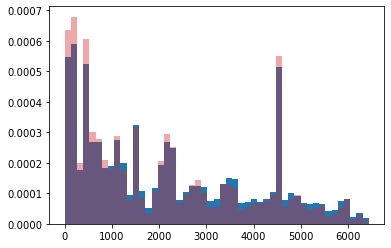

In [17]:
plot_bins(usrvidx_resvidx_tups_pos_DIST_sam)

### Create negative synthetic examples

In [14]:
#Through DIST method
usrvidx_resvidx_tups = get_entry_tupes(gur, max_hops=5, alpha=2, sd=13)
usrvidx_resvidx_tups_neg_DIST = filter_atts(gur, usrvidx_resvidx_tups, minth=0, maxth=3)
print('Num of neg examples:', len(usrvidx_resvidx_tups_neg_DIST))
print('Covered resources:', cov_resources(usrvidx_resvidx_tups_neg_DIST))

Num of neg examples: 81295
Covered resources: 0.9697251979506288


In [15]:
#Through RANDOM method
usrvidx_resvidx_tups = get_non_entries(gur, numentries=20000, sd=13)
usrvidx_resvidx_tups_neg_RANDOM = filter_atts(gur, usrvidx_resvidx_tups, minth=0, maxth=3)
print('Num of neg examples:', len(usrvidx_resvidx_tups_neg_RANDOM))
print('Covered resources:', cov_resources(usrvidx_resvidx_tups_neg_RANDOM))

Num of neg examples: 9848
Covered resources: 0.7342027635460332


In [18]:
num_neg_examples = 7250 #Because AZUCI has 145K edges (90-10)
random.seed(13)
usrvidx_resvidx_tups_neg_DIST_sam = random.sample(usrvidx_resvidx_tups_neg_DIST,num_neg_examples)
random.seed(13)
usrvidx_resvidx_tups_neg_RANDOM_sam = random.sample(usrvidx_resvidx_tups_neg_RANDOM,num_neg_examples)

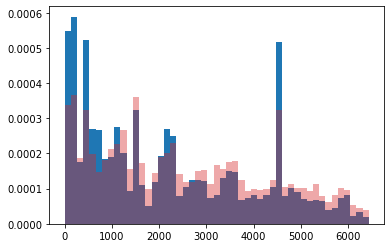

In [19]:
plot_bins(usrvidx_resvidx_tups_neg_DIST_sam)

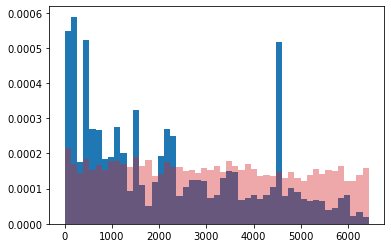

In [20]:
plot_bins(usrvidx_resvidx_tups_neg_RANDOM_sam)

In [21]:
def print_measures(num_pos, num_neg, num_truepos, num_falsepos):
    print('TPR (Recall):', num_truepos/num_pos)
    #print('FPR', num_falsepos/num_neg)
    recall = num_truepos/num_pos
    precision = num_truepos/(num_truepos+num_falsepos)
    fscore = 2*recall*precision/(recall+precision)
    print('Precision:', precision)
    print('Fscore:', fscore)
    
    num_trueneg = num_neg - num_falsepos
    acc = (num_truepos+num_trueneg)/(num_pos+num_neg)
    print('Accuracy:', acc)

### Evaluate biclique graph patterns

In [22]:
with open('data_structures/maxcc_azuci_bcs_v2.pkl', 'rb') as f:
    bcs = pickle.load(f)

print('Total bicliques:', len(bcs))

Total bicliques: 1082696


In [23]:
subbcs = []
for bc in bcs:
    if bc.get_pattern() != None and len(bc.get_pattern()) >= 2:
        subbcs.append(bc)

print('Selected bicliques:', len(subbcs))

Selected bicliques: 367728


In [24]:
with open('data_structures/azuci_bcgraph.pkl', 'rb') as f:
    bcgraph = pickle.load(f)

In [25]:
bcid_to_bc = {bc.get_id():bc for bc in subbcs}
gps = bcg.dfs(bcgraph, bcid_to_bc, sa=2)
print('Num graph patterns:', len(gps))

Num graph patterns: 9088


In [26]:
gps_final = []
for gpidx,gp in enumerate(gps):
    if len(gp[1]) < 50:
        gps_final.append(gp)

gps_final = [gp for gp in gps_final if len(gp[0])>1]

In [27]:
len(gps_final)

8831

In [28]:
#Create mappings
rules = [gp[0] for gp in gps_final]

bcid_to_ruleidxs = dict()
for ruleidx,gp in enumerate(gps_final):
    for bcid in gp[1]:
        if not bcid in bcid_to_ruleidxs:
            bcid_to_ruleidxs[bcid] = []
        bcid_to_ruleidxs[bcid].append(ruleidx)
        
#Agregado debido que ahora cargo el grafo de respaldo
bcid_to_bcidx = dict()
for bcidx,bc in enumerate(subbcs):
    bcid = bc.get_id()
    bcid_to_bcidx[bcid] = bcidx
    
resid_to_bcids = dict()
for bcv in bcgraph.vs:
    bcid = bcv['bcid']
    bc = subbcs[bcid_to_bcidx[bcid]]
    resids_ = bc.get_resids()
    for resid in resids_:
        if not resid in resid_to_bcids:
            resid_to_bcids[resid] = []
        resid_to_bcids[resid].append(bcid) 

In [29]:
def evaluate_bgp(gur, usrvidx_resvidx_tups):

    num_valid = 0
    num_trues = 0

    for tup in usrvidx_resvidx_tups:
        usrvidx = tup[0]
        resvidx = tup[1]
        usrattvals = userlog_objs[usrvidx]
        resid = int(gur.vs[resvidx]['name'][6:])

        if resid in resid_to_bcids:
            ruleidxs = set()
            for bcid in resid_to_bcids[resid]:
                if bcid in bcid_to_ruleidxs:
                    ruleidxs |= set(bcid_to_ruleidxs[bcid])

            ruleidxs = list(ruleidxs)

            if len(ruleidxs) > 0:
                num_valid += 1

            for ruleidx in ruleidxs:
                rule = rules[ruleidx]
                if len(set(usrattvals)&set(rule)) == len(rule):
                        num_trues += 1
                        break
                        
    return num_valid, num_trues
            


In [30]:
#Pos: dist, Neg: dist
num_pos_valid, num_truepos = evaluate_bgp(gur, usrvidx_resvidx_tups_pos_DIST_sam)
num_neg_valid, num_falsepos = evaluate_bgp(gur, usrvidx_resvidx_tups_neg_DIST_sam)
print_measures(num_pos_examples, num_neg_examples, num_truepos, num_falsepos)

TPR (Recall): 0.7566896551724138
Precision: 0.8561173533083646
Fscore: 0.8033387025918876
Accuracy: 0.8147586206896552


In [31]:
#Pos: dist, Neg: random
num_pos_valid, num_truepos = evaluate_bgp(gur, usrvidx_resvidx_tups_pos_DIST_sam)
num_neg_valid, num_falsepos = evaluate_bgp(gur, usrvidx_resvidx_tups_neg_RANDOM_sam)
print_measures(num_pos_examples, num_neg_examples, num_truepos, num_falsepos)

TPR (Recall): 0.7566896551724138
Precision: 0.9604341736694678
Fscore: 0.8464743095201358
Accuracy: 0.8627586206896551


### Evaluation frequent patterns

In [34]:
def evaluate_fp(gur, usrvidx_resvidx_tups, resid_to_patterns):
    num_valid = 0
    num_trues = 0
    for tup in usrvidx_resvidx_tups:
        usrvidx = tup[0]
        resvidx = tup[1]
        usrattvals = userlog_objs[usrvidx]
        resid = int(gur.vs[resvidx]['name'][6:])

        if len(resid_to_patterns[resid]) > 0:
            num_valid += 1

        for rule in resid_to_patterns[resid]:
            if len(set(usrattvals)&set(rule)) == len(rule):
                    num_trues += 1
                    break
                    
    return num_valid, num_trues
    

In [35]:
global_f = 20
resid_to_valsentries_20,resid_to_patterns_20 =\
avp.compute_avpatterns(gur, lmin=2, global_f=global_f, verbose=False)

In [36]:
#Pos: dist, Neg: dist
num_pos_valid, num_truepos = evaluate_fp(gur, usrvidx_resvidx_tups_pos_DIST_sam, resid_to_patterns_20)
num_neg_valid, num_falsepos = evaluate_fp(gur, usrvidx_resvidx_tups_neg_DIST_sam, resid_to_patterns_20)
print_measures(num_pos_examples, num_neg_examples, num_truepos, num_falsepos)

TPR (Recall): 0.852551724137931
Precision: 0.7912186379928315
Fscore: 0.8207409374585048
Accuracy: 0.8137931034482758


In [38]:
#Pos: dist, Neg: random
num_pos_valid, num_truepos = evaluate_fp(gur, usrvidx_resvidx_tups_pos_DIST_sam, resid_to_patterns_20)
num_neg_valid, num_falsepos = evaluate_fp(gur, usrvidx_resvidx_tups_neg_RANDOM_sam, resid_to_patterns_20)
print_measures(num_pos_examples, num_neg_examples, num_truepos, num_falsepos)

TPR (Recall): 0.852551724137931
Precision: 0.9402190447216306
Fscore: 0.894241898148148
Accuracy: 0.8991724137931034


In [39]:
global_f = 10
resid_to_valsentries_10,resid_to_patterns_10 =\
avp.compute_avpatterns(gur, lmin=2, global_f=global_f, verbose=False)

In [40]:
#Pos: dist, Neg: dist
num_pos_valid, num_truepos = evaluate_fp(gur, usrvidx_resvidx_tups_pos_DIST_sam, resid_to_patterns_10)
num_neg_valid, num_falsepos = evaluate_fp(gur, usrvidx_resvidx_tups_neg_DIST_sam, resid_to_patterns_10)
print_measures(num_pos_examples, num_neg_examples, num_truepos, num_falsepos)

TPR (Recall): 0.8855172413793103
Precision: 0.7713564820377268
Fscore: 0.8245039491427472
Accuracy: 0.8115172413793104


In [41]:
#Pos: dist, Neg: random
num_pos_valid, num_truepos = evaluate_fp(gur, usrvidx_resvidx_tups_pos_DIST_sam, resid_to_patterns_10)
num_neg_valid, num_falsepos = evaluate_fp(gur, usrvidx_resvidx_tups_neg_RANDOM_sam, resid_to_patterns_10)
print_measures(num_pos_examples, num_neg_examples, num_truepos, num_falsepos)

TPR (Recall): 0.8855172413793103
Precision: 0.9298957126303592
Fscore: 0.907164052564646
Accuracy: 0.9093793103448276
